In [2]:
from DBReader import SyncReader
from SensorsReaders import CANDecoder
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
import timeit
from rpl import RadarSignalProcessing
import sys
from DBReader import SyncReader
from scipy.interpolate import interp2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
#root_folder ='/home/yi/work/valeo_dataset/dataset/RECORD@2020-11-22_12.28.47/'
root_folder ='/home/yi/work/valeo_dataset/dataset/RECORD@2020-11-21_11.54.31/'

## Show the data in dataset

In [4]:
### Open the dataset
db = SyncReader(root_folder)
# if you leave the default parameters, the master sensor is the radar as it is the slowest one
# if you are interested by only the camera and laser scanner, you can call:
# db = SyncReader('dataset_path',master='camera',tolerance=200000)
# use print_info function to get all the details of the database content
db.print_info()
print('')

# Create an iterator on the dataset
ite = iter(db)
# ALl data are return in a dictionay
data=next(ite)
print(data.keys())
# and then each sensor returns a dictionary
print(data['camera'].keys())
print('')

-------------------------------------------------------------------------
- Sensors available:
-     camera
-     can
-     radar_ch3
-     scala
-     radar_ch1
-     gps
-     radar_ch0
-     radar_ch2
-
- You might use function "setSensorFilters" to select sensors you want to read!
-------------------------------------------------------------------------
Total tolerance errors:  0.15698587127158556 %
Total corrupted frames:  3.6891679748822606 %
Available sensors:
# Sensor:  camera
	- filename:  /home/yi/work/valeo_dataset/dataset/RECORD@2020-11-21_11.54.31/RECORD@2020-11-21_11.54.31_camera.mjpg
	- Nb Samples:  7531
	- Duration:  257 sec
	- Update rate:  34.21647390784756 ms
# Sensor:  can
	- filename:  /home/yi/work/valeo_dataset/dataset/RECORD@2020-11-21_11.54.31/RECORD@2020-11-21_11.54.31_can.bin
	- Nb Samples:  5302
	- Duration:  257 sec
	- Update rate:  48.60960222557525 ms
# Sensor:  radar_ch3
	- filename:  /home/yi/work/valeo_dataset/dataset/RECORD@2020-11-21_11.54.31/RECORD@

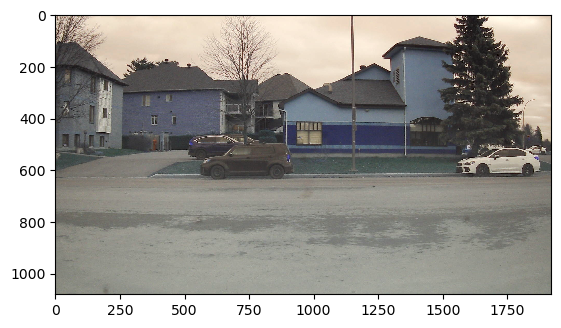

In [5]:
# or you can direct access specific index
data = db.GetSensorData(0)
plt.imshow(data['camera']['data'])

In [6]:
def Own_GetMostRecentOdometry(can_decoder,timestamp) :
    IDX = np.where(db.can_frames['ID']==485)[0]
    timediff = np.abs(db.can_frames['timestamp'][IDX] - timestamp)
    id_steer = IDX[np.argmin(timediff)]
    message = can_decoder.decode([{'timestamp':db.can_frames['timestamp'][id_steer],'ID':int(db.can_frames['ID'][id_steer]),'DATA':db.can_frames['data'][id_steer]}])
    SteeringWheel = message[0]['signals']['Steering_Wheel_Angle_deg']

    # Yaw: 489
    IDX = np.where(db.can_frames['ID']==489)[0]
    timediff = np.abs(db.can_frames['timestamp'][IDX] - timestamp)
    id_yaw = IDX[np.argmin(timediff)]
    message = can_decoder.decode([{'timestamp':db.can_frames['timestamp'][id_yaw],'ID':int(db.can_frames['ID'][id_yaw]),'DATA':db.can_frames['data'][id_yaw]}])
    YawRate = message[0]['signals']['YawRate_deg']
            
    # Speed: ID=1001
    IDX = np.where(db.can_frames['ID']==1001)[0]
    timediff = np.abs(db.can_frames['timestamp'][IDX] - timestamp)
    id_speed = IDX[np.argmin(timediff)]
    message = can_decoder.decode([{'timestamp':db.can_frames['timestamp'][id_speed],'ID':int(db.can_frames['ID'][id_speed]),'DATA':db.can_frames['data'][id_speed]}])
    VehSpd = message[0]['signals']['Speed_kph']
    return VehSpd,YawRate,SteeringWheel

In [7]:
# you can get also the odometry at a defined timestamp
timestamp = data['camera']['timestamp']

# you need to provide the dbc decoder
can_decoder = CANDecoder('can_database.dbc')


# Problem in the decode part, so we do it in own way
# odometry = db.GetMostRecentOdometry(can_decoder,timestamp)

odometry = Own_GetMostRecentOdometry(can_decoder,timestamp)
odometry = np.asarray(odometry)
odometry[0] = odometry[0]*1.0*1000/3600
odometry[1] = odometry[1]*1.0/180*np.pi
print('Speed (mps):',odometry[0])
print('yaw rate (rad/sec):',odometry[1]) #base on observation -0+ in Veh C.S.
print('Steering wheel angle (degree):',odometry[2])

Speed (mps): 0.0
yaw rate (rad/sec): 0.0
Steering wheel angle (degree): 12.5


## 2. RadarSignalProcessing to compute Point Cloud 

In [8]:
#root_folder ='/home/yi/work/valeo_dataset/RECORD@2020-11-21_11.54.31/'
#db = SyncReader(root_folder,tolerance=40000)

select_idx = 0#90
sample = db.GetSensorData(select_idx)
#plt.imshow(sample['camera']['data'])

In [9]:
# mountatin position, 2013 Buick Enclave
wheelbase = 0.0254*118.09#inch to meter
track = 0.0254*67.1
radar_pos = np.array([wheelbase+1,0,0.8])#veh C.S (x,y,z), z relative to ground
lidar_pos = np.array([wheelbase+1,0,0.42])

# you can get also the odometry at a defined timestamp
timestamp = sample['radar_ch0']['timestamp']

# you need to provide the dbc decoder
can_decoder = CANDecoder('can_database.dbc')

# Problem in the decode part, so we do it in own way
# odometry = db.GetMostRecentOdometry(can_decoder,timestamp)
odometry = Own_GetMostRecentOdometry(can_decoder,timestamp)
odometry = np.asarray(odometry)
odometry[0] = odometry[0]*1.0*1000/3600
odometry[1] = odometry[1]*1.0/180*np.pi
print('Speed (mps):',odometry[0])
print('yaw rate (rad/sec):',odometry[1]) #base on observation -0+ in Veh C.S.
print('Steering wheel angle (degree):',odometry[2])


v_radar = np.array([odometry[0],-odometry[1]*radar_pos[0],0])#veh C.S


Speed (mps): 0.0
yaw rate (rad/sec): 0.0
Steering wheel angle (degree): 12.5


CPU will be used to execute the processing
CPU times: user 1.53 s, sys: 74.5 ms, total: 1.61 s
Wall time: 240 ms


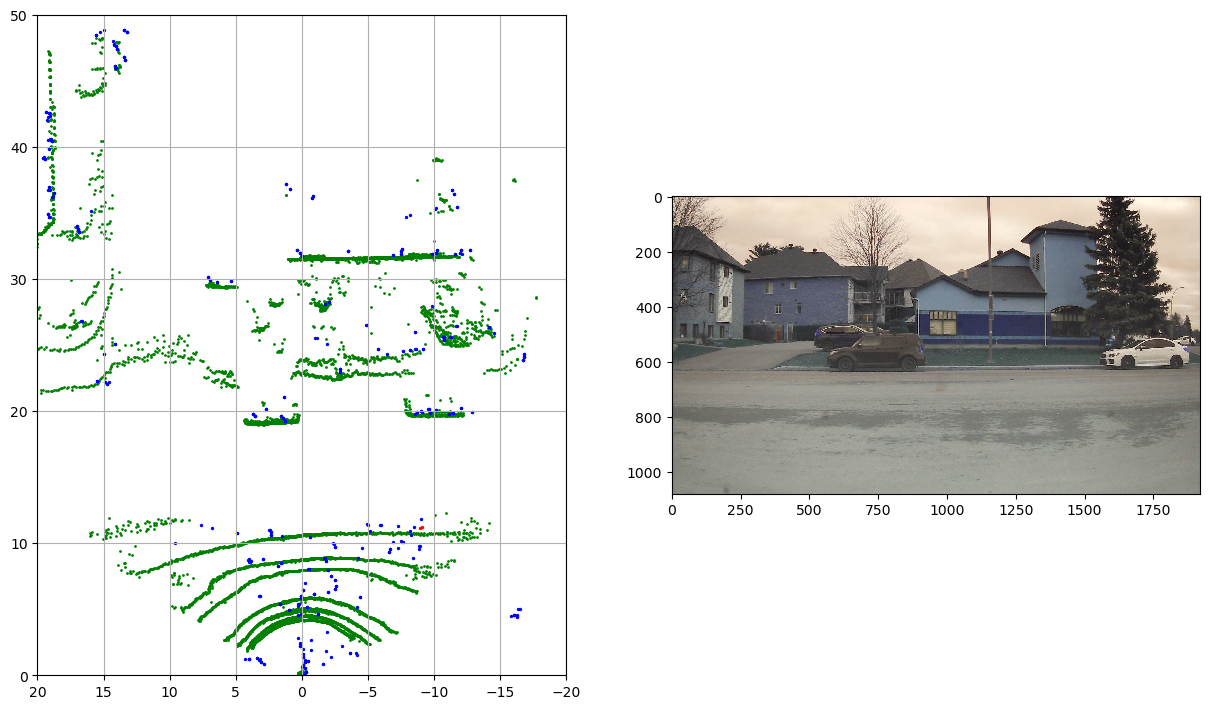

In [10]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='PC')
%time pc=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])
Az = pc[:,2] # +|- vehicel C.S. rad
R = pc[:,0]
El = pc[:,3] #up(+)0down(-), rad
Do = pc[:,1] 
#doppler shift
#0-127|128-255 
doppler_resolution = 0.1#m/s
num_doppler_bin = 256
posi_doppler_axis = doppler_resolution*np.arange(num_doppler_bin/2)
negi_doppler_axis = -1*doppler_resolution*np.arange(num_doppler_bin/2,0,-1)
doppler_axis_mps = np.concatenate((negi_doppler_axis.reshape(-1,1),posi_doppler_axis.reshape(-1,1)),axis=0)
doppler_axis_mps = doppler_axis_mps.reshape(-1,)
posi_side = np.where(Do<num_doppler_bin/2)[0]
negi_side = np.where(Do>=num_doppler_bin/2)[0]
Do_shift = np.copy(Do)
Do_shift[posi_side]  = Do_shift[posi_side] + num_doppler_bin/2
Do_shift[negi_side]  = Do_shift[negi_side] - num_doppler_bin/2
Do_shift = np.array(Do_shift,dtype=int)

vel_threshold = 1.5 #m/s
moving_sign = np.abs(doppler_axis_mps[Do_shift]*np.cos(El)+ v_radar[0]*np.cos(Az)+v_radar[1]*np.sin(Az))> vel_threshold
doppler_com = (doppler_axis_mps[Do_shift]+ v_radar[0]*np.cos(Az)+v_radar[1]*np.sin(Az))*moving_sign.astype(int)#approach -,leave +

pts = sample['scala']['data']
fig=plt.figure(figsize=(15,15))
plt.tight_layout()
ax1=fig.add_subplot(121)
ax1.set_aspect('equal')
plt.scatter(pts[:,1],pts[:,0],s=1,color='green')#pts: x,y (Veh C.S.)
#lidar_plt=plt.scatter(pts[:,1],pts[:,0],s=1,c=pts[:,2]+lidar_h,zorder=1,vmin=-1,vmax=2,cmap='jet')
plt.xlim(20,-20)
plt.ylim(0,50)


plt.grid()
#select_detidx =  np.logical_and(np.logical_and(R>10,R<25),doppler_com!=0)
#plt.scatter(R[select_detidx] *np.sin(Az[select_detidx])*np.cos(El[select_detidx]),R[select_detidx]*np.cos(Az[select_detidx])*np.cos(El[select_detidx]),s=2,color='red')
plt.scatter(R[moving_sign==1] *np.sin(Az[moving_sign==1])*np.cos(El[moving_sign==1]),R[moving_sign==1]*np.cos(Az[moving_sign==1])*np.cos(El[moving_sign==1]),s=2,color='red')
plt.scatter(R[moving_sign==0] *np.sin(Az[moving_sign==0])*np.cos(El[moving_sign==0]),R[moving_sign==0]*np.cos(Az[moving_sign==0])*np.cos(El[moving_sign==0]),s=2,color='blue')
#plt.scatter(R*np.sin(Az)*np.cos(El),R*np.cos(Az)*np.cos(El),s=2,color='blue')
#plt.scatter(R*np.sin(Az)*np.cos(El),R*np.cos(Az)*np.cos(El),s=5,c=R*np.sin(El)+radar_h,zorder=2,vmin=-1,vmax=2,cmap='jet')



# divider3 = make_axes_locatable(ax1)
# cax3 = divider3.append_axes('right',size='5%',pad=0.2)
# cbar3 =plt.colorbar(lidar_plt,cax=cax3,extend='both',extendrect=True)
# cbar3.set_label(label='height',size=14)

ax2 = fig.add_subplot(122)
ax2.imshow(sample['camera']['data'] )

In [11]:
select_detidx = np.logical_and(R>5,R<60)

(-30, 30)

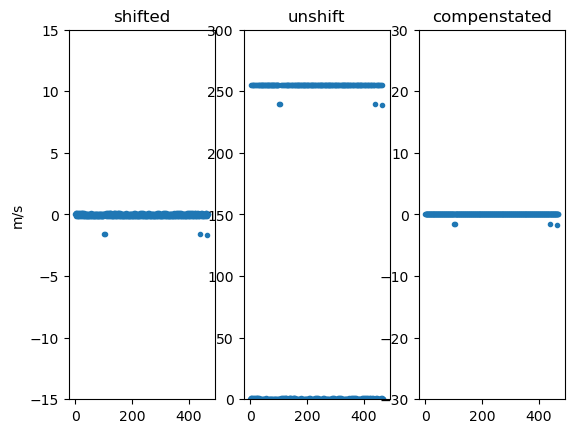

In [12]:
fig =plt.figure()
ax1=fig.add_subplot(131)
ax1.plot(doppler_axis_mps[Do_shift.astype(int)[select_detidx ]]  ,'.')
ax1.set_title('shifted')
ax1.set_ylim([-15,15] )
ax1.set_ylabel('m/s')
ax2=fig.add_subplot(132)
ax2.plot(Do[select_detidx],'.')
ax2.set_title('unshift')
ax2.set_ylim([0,300] )
ax3=fig.add_subplot(133)
ax3.plot(doppler_com[select_detidx],'.')
ax3.set_title('compenstated')
ax3.set_ylim([-30,30] )

## 3. RadarSignalProcessing to compute Doppler Spectrums

CPU will be used to execute the processing
CPU times: user 228 ms, sys: 73.2 ms, total: 301 ms
Wall time: 70.9 ms
(512, 256, 16) It has 16 channels, one for each Rx antenna


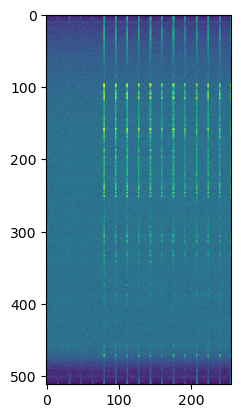

In [13]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='RD')
%time rd=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])
print(rd.shape,'It has 16 channels, one for each Rx antenna')
plt.imshow(20*np.log10(np.sum(np.abs(rd),axis=2)))

## 4. RadarSignalProcessing to compute Range-Azimuth map

PyTorch on GPU will be used to execute the processing
CPU times: user 2.23 s, sys: 273 ms, total: 2.5 s
Wall time: 728 ms


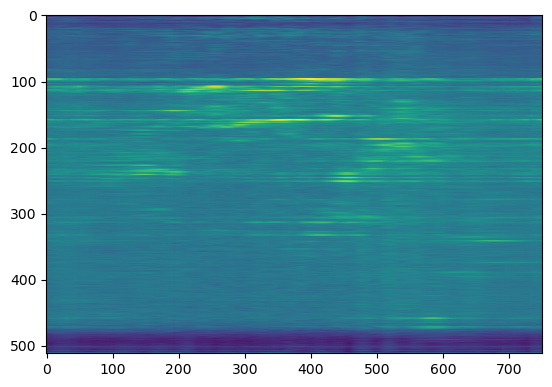

In [14]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='RA',device='cuda',lib='PyTorch')
%time ra=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])
AoA_mat = np.load('/home/yi/work/valeo_dataset/RADIal_code/SignalProcessing/CalibrationTable.npy',allow_pickle=True).item()
plt.imshow(20*np.log10(np.abs(ra)))
#plt.colorbar()

PyTorch on GPU will be used to execute the processing
CPU times: user 1.93 s, sys: 148 ms, total: 2.08 s
Wall time: 320 ms


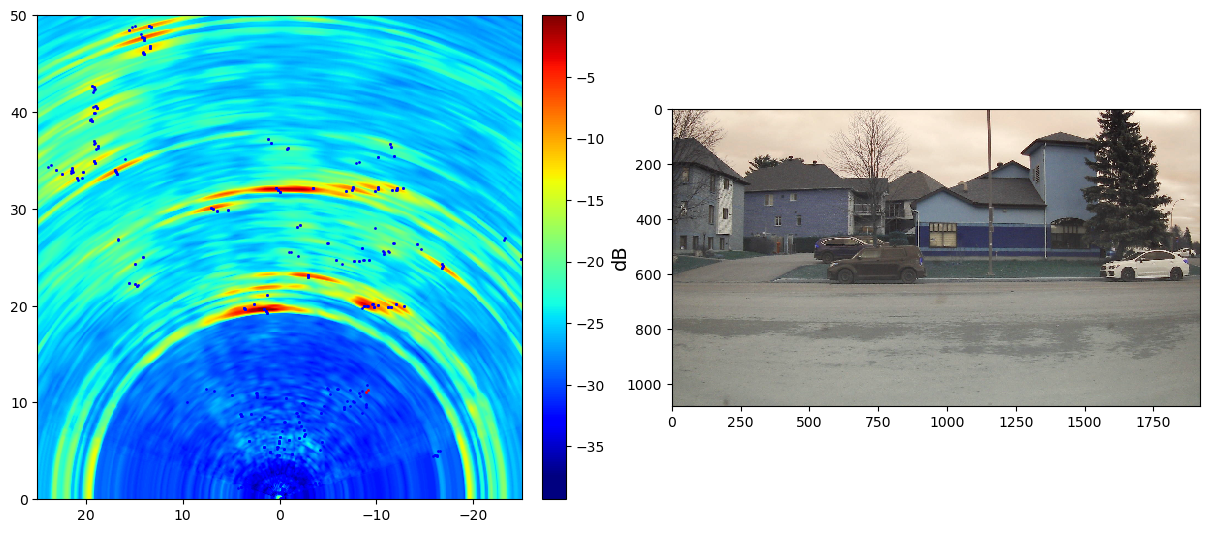

In [36]:

RSP = RadarSignalProcessing('CalibrationTable.npy',method='RA',device='cuda',lib='PyTorch')

%time ra=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

Num_R_Bin = 512

sin_azi_axis = np.sin(np.deg2rad(AoA_mat['Azimuth_table'])) #deg
r_axis = np.arange(Num_R_Bin)/Num_R_Bin*103.
cellsize = 0.1
x_veh_lim = 50
y_veh_lim = 25
radar_h = 0.8 # m
lidar_h = 0.42 # m
x_veh = np.arange(x_veh_lim,0-cellsize,-cellsize)
y_veh = np.arange(y_veh_lim,-y_veh_lim-cellsize,-cellsize)
y_veh_mesh,x_veh_mesh = np.meshgrid(y_veh,x_veh)
##RA Cartesian
r_veh_mesh = np.sqrt(np.square(x_veh_mesh)+np.square(y_veh_mesh))
sin_azi_veh_mesh = y_veh_mesh/(r_veh_mesh+np.finfo(np.float32).eps)
F =interp2d(r_axis,sin_azi_axis,ra.T)
ra_cartesian =[]
r_veh_mesh = np.ravel(r_veh_mesh)
sin_azi_veh_mesh = np.ravel(sin_azi_veh_mesh)
for i in range(len(r_veh_mesh)):
    ra_cartesian.append(F(r_veh_mesh[i],sin_azi_veh_mesh[i]))
ra_cartesian = np.asarray(ra_cartesian).reshape(y_veh_mesh.shape[0],y_veh_mesh.shape[1])  
ra_cartesian = np.fliplr(ra_cartesian)# because the x axis is reversed
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(121)
ax.set_xlim([y_veh_lim,-y_veh_lim] )
ax.set_ylim([0,x_veh_lim] )
ax.set_aspect('equal')
ra_cartesian = ax.imshow(20*np.log10(ra_cartesian/np.max(ra_cartesian)),vmax=0,zorder=0,cmap='jet',extent=[-y_veh_lim,y_veh_lim,0,x_veh_lim] )

##process radar point cloud
Az = pc[:,2] 
R = pc[:,0]
El = pc[:,3] 
Do = pc[:,1] 
pts = sample['scala']['data']
#doppler shift
#0-127|128-255 
doppler_resolution = 0.1#m/s
num_doppler_bin = 256
posi_doppler_axis = doppler_resolution*np.arange(num_doppler_bin/2)
negi_doppler_axis = -1*doppler_resolution*np.arange(num_doppler_bin/2,0,-1)
doppler_axis_mps = np.concatenate((negi_doppler_axis.reshape(-1,1),posi_doppler_axis.reshape(-1,1)),axis=0)
doppler_axis_mps = doppler_axis_mps.reshape(-1,)
posi_side = np.where(Do<num_doppler_bin/2)[0]
negi_side = np.where(Do>=num_doppler_bin/2)[0]
Do_shift = np.copy(Do)
Do_shift[posi_side]  = Do_shift[posi_side] + num_doppler_bin/2
Do_shift[negi_side]  = Do_shift[negi_side] - num_doppler_bin/2
Do_shift = np.array(Do_shift,dtype=int)

vel_threshold = 1.5 #m/s
moving_sign = np.abs(doppler_axis_mps[Do_shift]*np.cos(El)+ v_radar[0]*np.cos(Az)+v_radar[1]*np.sin(Az))> vel_threshold
doppler_com = (doppler_axis_mps[Do_shift]+ v_radar[0]*np.cos(Az)+v_radar[1]*np.sin(Az))*moving_sign.astype(int)#approach -,leave +

##lidar
plt.scatter(pts[:,1],pts[:,0],s=1,color='green',zorder=1)
##radar
plt.scatter(R[moving_sign==1] *np.sin(Az[moving_sign==1])*np.cos(El[moving_sign==1]),
    R[moving_sign==1]*np.cos(Az[moving_sign==1])*np.cos(El[moving_sign==1]),s=1,color='red',zorder=2)
plt.scatter(R[moving_sign==0] *np.sin(Az[moving_sign==0])*np.cos(El[moving_sign==0]),
    R[moving_sign==0]*np.cos(Az[moving_sign==0])*np.cos(El[moving_sign==0]),s=1,color='blue',zorder=2)
##camera img
ax2 = fig.add_subplot(122)
ax2.imshow(sample['camera']['data'] )
##colorbar
divider3 = make_axes_locatable(ax)
cax3 = divider3.append_axes('right',size='5%',pad=0.2)
cbar3 =plt.colorbar(ra_cartesian,cax=cax3,extend='min',extendrect=True)
cbar3.set_label(label='dB',size=14)